In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex

# Utils
from utils.data_utils import load_cmsopendata
from utils.plot_utils import plot_event

# Jets
from pyjet import cluster


/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Data

Max # of particles: 112
Max # of particles: 126
test
(1000,)


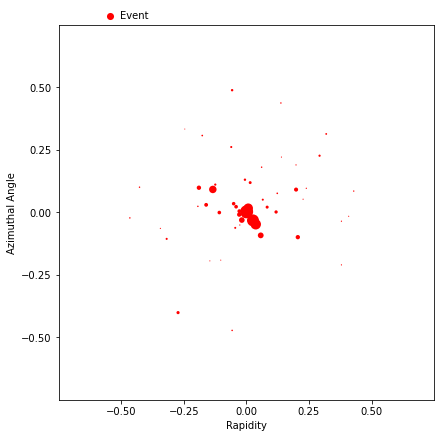

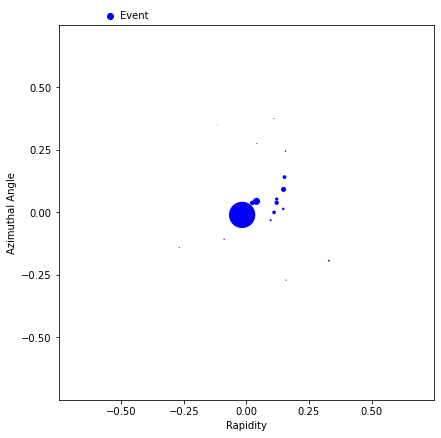

In [2]:
# Parameters
R = 0.5
beta = 1.0
N = 10000
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N)
sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)
print(cms_weights.shape)




# signal, signal_masses = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta_cut)
# background, background_masses = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta_cut)
# events = [signal, background]
# event_labels = ["signal", "background"]
# colors = ["red", "blue"]


fake_top, fake_top_z = np.array(( (-1.0,0.0), (0.0,0.0), (1.0,0.0),)), np.array((1/3, 1/3, 1/3))
fake_signal = ((fake_top, fake_top_z), )
fake_quark, fake_quark_z = np.array(((0.0,0.0),)), np.array((1.0, ))
fake_background = ((fake_quark, fake_quark_z),)
fake_events = [fake_signal, fake_background]


# Example plots
example_cms = cms[0]
plot_event(example_cms[0], example_cms[1], R, color = "red")

example_sim = sim[0]
plot_event(example_sim[0], example_sim[1], R, color = "blue")


In [3]:
import torch 
import torch.nn as nn


# Sample from a normalized uniform distribution
def uniform_sampler(N, param_dict):
    points = torch.FloatTensor(N, 2).uniform_(-R, R)
    zs = torch.ones((N,)) / N
    return (points, zs)

# Sample at N weighted Dirac deltas
def point_sampler(N, param_dict):
    return (param_dict["Points"].params, param_dict["Weights"].params)

# Basic Observables
_isotropy = Observable({}, uniform_sampler, beta = 1, R = 0.8)
_1subjettiness = Observable({"Points" : Coordinates2D(1), "Weights" : Simplex(1)}, point_sampler, beta = 1, R = R, initializer= "kt")
_2subjettiness = Observable({"Points" : Coordinates2D(2), "Weights" : Simplex(2)}, point_sampler, beta = 1, R = R, initializer= "kt")
_3subjettiness = Observable({"Points" : Coordinates2D(3), "Weights" : Simplex(3)}, point_sampler, beta = 1, R = R, initializer= "kt")
_MAXsubjettiness = Observable({"Points" : Coordinates2D(pad), "Weights" : Simplex(pad)}, point_sampler, beta = 1, R = R, initializer= "kt")

# # Composite Observables
# _3subjettiness_plus_pileup = _3subjettiness + _isotropy
rho = 0.1
_apollonius = (_MAXsubjettiness + _isotropy)
_apollonius.freeze("Joint Weights", np.array([1 - rho, rho]))

# _MAXsubjettiness.initialize(signal[0])
# _apollonius.initialize(signal[0])
print(list(_MAXsubjettiness.named_parameters()))
print(list(_apollonius.named_parameters()))

# List of observables we want to calculate
observables = {
    # "Isotropy" : _isotropy,
    # "1 Subjettiness" : _1subjettiness,
    # "2 Subjettiness" : _2subjettiness,
    # "3 Subjettiness" : _3subjettiness,
    # "MAX Subjettiness" : _MAXsubjettiness,
    # "3 Subjettiness + Pileup" : _3subjettiness_plus_pileup,
    # "Apollonius" : _apollonius
}
shaper = Shaper(observables)


signal_emds, signal_params = shaper.calculate(cms, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 25)
background_emds, background_params = shaper.calculate(sim, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 25)



[('params.Points.params', Parameter containing:
tensor([[ 0.6691,  0.8043],
        [ 0.4433, -0.2599],
        [ 0.8303, -0.4611],
        [ 0.4825, -0.2490],
        [-0.2321, -0.3760],
        [-0.1235, -0.2266],
        [ 0.1648, -0.3086],
        [ 0.2681,  0.9871],
        [ 0.6656, -0.2829],
        [ 0.6691, -0.6342],
        [-0.5158, -0.8539],
        [-0.5010,  0.6528],
        [-0.9452,  0.3279],
        [-0.1025,  0.7974],
        [ 0.4944, -0.5372],
        [-0.9852,  0.9081],
        [-0.2974,  0.4414],
        [ 0.5374,  0.9508],
        [ 0.1824,  0.9277],
        [-0.1353,  0.9600],
        [ 0.4025,  0.3981],
        [-0.5163, -0.2848],
        [ 0.0131,  0.5504],
        [ 0.4380, -0.5371],
        [ 0.8367, -0.6684],
        [-0.3149,  0.4686],
        [ 0.1212,  0.9323],
        [ 0.4536, -0.5577],
        [ 0.5304,  0.9927],
        [-0.3257,  0.5652],
        [-0.9623, -0.8699],
        [ 0.0261,  0.5964],
        [ 0.6337,  0.6572],
        [ 0.2585,  0.3937],


In [4]:
# plt.hist(signal_emds["2 Subjettiness"] / signal_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["2 Subjettiness"] / background_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()
# plt.show()

# plt.hist(signal_emds["3 Subjettiness"] / signal_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["3 Subjettiness"] / background_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()

# Benchmarks - Apollonius

In [5]:
# Interpolate between max subjettiness, ---rhos--- isotropy
rhos = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
observables = {"MAX Subjettiness": _MAXsubjettiness}
for rho in rhos:
    _apollonius = (_MAXsubjettiness + _isotropy)
    _apollonius.freeze("Joint Weights", np.array([1 - rho, rho]))
    observables["Apollonius %d" % (rho * 10)] = _apollonius
observables["Isotropy"] = _isotropy

shaper = Shaper(observables)

# print(signal[0][1])
cms_emds, _ = shaper.calculate(cms, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_emds, _ = shaper.calculate(sim, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)
_ = 0

Observable: MAX Subjettiness Epoch 0 Mean Loss = 6.382432360396706e-13 Elapsed time = 19.577s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 1 Mean Loss = 5.23944292183387e-06 Elapsed time = 25.507s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 2 Mean Loss = 5.240665282713053e-06 Elapsed time = 31.574s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 3 Mean Loss = 5.240665282713053e-06 Elapsed time = 37.432s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 4 Mean Loss = 5.240665282713053e-06 Elapsed time = 43.366s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 5 Mean Loss = 5.240665282713053e-06 Elapsed time = 49.188s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 6 Mean Loss = 5.240665282713053e-06 Elapsed time = 49.519s Percentage done = 99.800 
Observable: MAX Subjettiness Epoch 7 Mean Loss = 5.240665282713053e-06 Elapsed time = 49.817s Percentage done = 99.800 
Observable: MAX Subjettiness Epoch 8 Mean Loss 

KeyboardInterrupt: 

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

# print(signal_emds, background_emds)

for (i, rho) in enumerate(rhos):
    sg_ys.append(np.mean(cms_emds["Apollonius %d" %i]))
    sg_errs.append(np.std(cms_emds["Apollonius %d" %i]))
    bg_ys.append(np.mean(sim_emds["Apollonius %d" %i]))
    bg_errs.append(np.std(sim_emds["Apollonius %d" %i]))

plt.errorbar(np.array(rhos) + 0.01, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(rhos, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
plt.axhline(np.mean(cms_emds["Isotropy"]), color = "red", linestyle = "--")
plt.axhline(np.mean(sim_emds["Isotropy"]), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "CMS Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "SIM Jets"),
                 Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),]
plt.legend(handles = custom_legend)
plt.xlabel(r"$\rho$")
plt.ylabel("EMD")
plt.title("Apollonius EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
range = [.2, 1.0]
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_emds[obs] / np.max(sim_emds[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



plot_hist("Apollonius 2", "red", r"$\rho = 0.2$")
plot_hist("Isotropy", "blue", "Isotropy")
# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'Apollonius EMD / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()


In [ ]:
# How far is each event from its (normalized) corrected event?

for rho in rhos:
    observables["Apollonius %d" % (rho * 10)].freeze("Weights")
    observables["Apollonius %d" % (rho * 10)].freeze("Joint Weights")

# Benchmarks - Nsubjettiness

In [6]:
# Interpolate between max subjettiness, ---rhos--- isotropy
N = np.arange(1,126)
observables = {}
for n in N:

    _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    observables["%d-Subjettiness" % n] = _nsubjettiness

shaper = Shaper(observables)

# print(signal[0][1])
cms_njettiness, _ = shaper.calculate(cms, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_njettiness, _ = shaper.calculate(sim, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)

Observable: 1-Subjettiness Epoch 0 Mean Loss = 0.05937759596575051 Elapsed time = 2.499s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 1 Mean Loss = 0.0600503443852067 Elapsed time = 4.630s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 2 Mean Loss = 0.058112706052139404 Elapsed time = 6.754s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 3 Mean Loss = 0.057559326253365725 Elapsed time = 8.885s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 4 Mean Loss = 0.057987841159105304 Elapsed time = 11.130s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 5 Mean Loss = 0.05779692351166159 Elapsed time = 13.276s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 6 Mean Loss = 0.0575312482425943 Elapsed time = 15.024s Percentage done = 31.300 
Observable: 1-Subjettiness Epoch 7 Mean Loss = 0.05739187140204012 Elapsed time = 16.496s Percentage done = 42.100 
Observable: 1-Subjettiness Epoch 8 Mean Loss = 0.05741136644594371 Elapsed time =

<ipython-input-60-a208088f0145>:19: RuntimeWarning: divide by zero encountered in true_divide
  sg_ys.append(np.mean(np.nan_to_num(cms_njettiness["%d-Subjettiness" % n] / cms_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
/home/rikab/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-60-a208088f0145>:20: RuntimeWarning: divide by zero encountered in true_divide
  sg_errs.append(np.std(cms_njettiness["%d-Subjettiness" % n]/ cms_njettiness["%d-Subjettiness" % (n-1)])*0)
/home/rikab/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-60-a208088f0145>:21: RuntimeWarning: divide by zero encountered in true_divide
  bg_ys.append(np.mean(np.nan_to_num(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
<i

125 (125,)


<ipython-input-60-a208088f0145>:19: RuntimeWarning: invalid value encountered in true_divide
  sg_ys.append(np.mean(np.nan_to_num(cms_njettiness["%d-Subjettiness" % n] / cms_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
<ipython-input-60-a208088f0145>:20: RuntimeWarning: invalid value encountered in true_divide
  sg_errs.append(np.std(cms_njettiness["%d-Subjettiness" % n]/ cms_njettiness["%d-Subjettiness" % (n-1)])*0)
<ipython-input-60-a208088f0145>:21: RuntimeWarning: invalid value encountered in true_divide
  bg_ys.append(np.mean(np.nan_to_num(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
<ipython-input-60-a208088f0145>:22: RuntimeWarning: invalid value encountered in true_divide
  bg_errs.append(np.std(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)])*0)
/home/rikab/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, a

Text(0.5, 1.0, 'N-Subjettiness EMD Distribution')

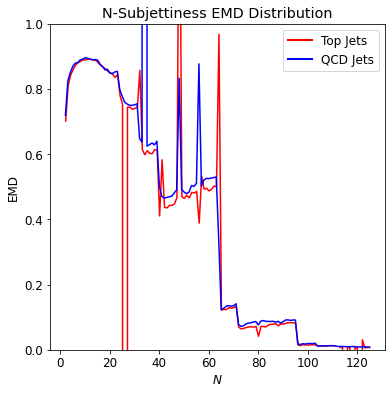

In [60]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'



cms_njettiness["0-Subjettiness"] = np.zeros_like(cms_njettiness["1-Subjettiness"])
sim_njettiness["0-Subjettiness"] = np.zeros_like(sim_njettiness["1-Subjettiness"])

# print(signal_emds, background_emds)

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

for n in N:
    sg_ys.append(np.mean(np.nan_to_num(cms_njettiness["%d-Subjettiness" % n] / cms_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    sg_errs.append(np.std(cms_njettiness["%d-Subjettiness" % n]/ cms_njettiness["%d-Subjettiness" % (n-1)])*0)
    bg_ys.append(np.mean(np.nan_to_num(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    bg_errs.append(np.std(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)])*0)


print(len(sg_ys), N.shape)

plt.errorbar(N + 0.1, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(N, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# # plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
# plt.axhline(np.mean(signal_emds["Isotropy"] * 0.95), color = "red", linestyle = "--")
# plt.axhline(np.mean(background_emds["Isotropy"] * 0.94), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "Top Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "QCD Jets"),
                #  Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),
                 ]
plt.legend(handles = custom_legend)
plt.xlabel(r"$N$")
plt.ylabel("EMD")
# plt.yscale("log")
plt.ylim([0,1])
plt.title("N-Subjettiness EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

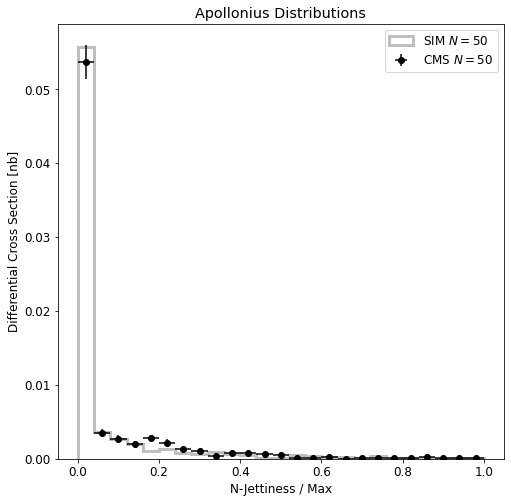

In [49]:
range = [0, 1]
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_njettiness[obs] / np.max(cms_njettiness[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



# plot_hist("1-Subjettiness", "red", r"$N = 1$")
# plot_hist("2-Subjettiness", "orange", r"$N = 2$")
# plot_hist("3-Subjettiness", "yellow", r"$N = 3$")
# plot_hist("5-Subjettiness", "green", r"$N = 5$")
# plot_hist("10-Subjettiness", "blue", r"$N = 10$")
# plot_hist("25-Subjettiness", "purple", r"$N = 25$")
plot_hist("50-Subjettiness", "black", r"$N = 50$")

# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'N-Jettiness / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()

# Benchmarks - Isotopy
My code vs. Cari's

In [ ]:
ym = 0.8
norm = 12.0/(np.pi*np.pi+16*ym*ym)

# Reference Event
n = 15
points = []
zs = []
for y in np.linspace(-0.8, 0.8, n):
    for phi in np.linspace(-0.8, 0.8, n):

        points.append((y, phi))
        zs.append(1.0 / (n**2))
refernce_event = (np.array(points), np.array(zs))

In [ ]:
from ot.lp import emd2


emds_old = np.zeros(shape = (len(events), N))
times_old = np.zeros(shape = (len(events), N))

def _cdist_phi_y(X,Y, ym):
    # define ym as the maximum rapidity cut on the quasi-isotropic event
    # Make sure the phi values are in range                                                                                                                                          
    phi1 = (X[:,1])
    phi2 = (Y[:,1])
    # Trick to account for phi distance periodicity
    phi_d = ((phi1[:,np.newaxis] - phi2[:])) 
    norm = 12.0/(np.pi*np.pi+16*ym*ym)
    y_d = X[:,0,np.newaxis] - Y[:,0]
    dist = norm * (phi_d**2 + y_d**2)
    return dist

# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
        for (k, event) in enumerate(events[i]):

            t1 = time()
            xi, ai = event
            yj, bj = refernce_event
            M = _cdist_phi_y(xi, yj, 0.8)
            emd_val, log = emd2(ai.astype(np.float64) / ai.sum().astype(np.float64), bj.astype(np.float64)/ bj.sum().astype(np.float64), M,log=True)
            # Should only return 0 when two events are identical. If returning 0 otherwise, problems in config
            if emd_val==0:
                print(log['warning'])
            emds_old[i,k] = emd_val
            t2 = time()
            times_old[i,k] = t2 - t1

            print("Event %d" %k, "Class: %s" % event_labels[i], "Value: %.6f" % emd_val, "Finished in %.3fs" % (t2 - t1))

print(np.sum(times_old))

In [ ]:
labels = ["Isotropy"]
epsilons = [0.0001, 0.001, 0.01, 0.1, 0.99]

emds_sinkhorn = np.zeros(shape = (len(events), len(epsilons), N))
times_sinkhorn = np.zeros(shape = (len(events), len(epsilons)))

def uniform_grid(N, param_dict):

        n = int(np.sqrt(N))
        points = []
        zs = []
        for y in np.linspace(-0.8, 0.8, n):
                for phi in np.linspace(-0.8, 0.8, n):

                        points.append((y, phi))
                        zs.append(1.0 / (n**2))
        return (torch.Tensor(points), torch.Tensor(zs))


isotropy = Observable({}, uniform_grid, beta = 2, R = 1)
shaper = Shaper({"Isotropy": isotropy})


# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
        for (e, eps) in enumerate(epsilons):

                t1 = time()
                emd = shaper.calculate(events[i], epochs= 500, lr = 0.05, beta=2, N = 225, epsilon=eps, scaling = 0.75)
                emds_sinkhorn[i,e,:] = (emd["Isotropy"] * norm).detach().numpy()
                t2 = time()
                times_sinkhorn[i,e] = t2 - t1

                print("Obs: %s-%.1e" % (labels[0], eps), "Class: %s" % event_labels[i], "Finished in %.3fs" % (t2 - t1))

print(np.sum(times_sinkhorn))


In [ ]:
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for (e, eps) in enumerate(epsilons):
    print(np.mean(emds_sinkhorn[0,e,:] / norm))
    # plt.hist(emds_old[0,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Signal Old", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds_sinkhorn[0,e,:] , bins = 25, range=(0.00, 0.1), density = True, color = "red", label = "Signal $\epsilon$ = %.1f" % eps, histtype="step", alpha = (len(epsilons)- e) / len(epsilons), lw = 3)
print(np.mean(emds_old[0,:] /2 / emds_sinkhorn[0,0,:]))
plt.hist(emds_old[0,:] /2, bins = 25, range=(0.00, 0.1), density = True, color = "Black", label = "Signal POT", histtype="step", lw = 3)
plt.title(r"Event Isotropy ($25\times25$)" )
plt.xlabel(r"Isotropy" )
plt.ylabel(r"Density" )
plt.legend()
# plt.savefig("Plots/signal_annealing.pdf")
plt.show()
    
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for (e, eps) in enumerate(epsilons):

    # plt.hist(emds_old[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds_sinkhorn[1,e,:] , bins = 25, range=(0.00, 0.1), density = True, color = "blue", label = "Background $\epsilon$ = %.1f" % eps, histtype="step", alpha = (len(epsilons)- e) / len(epsilons), lw = 3)
plt.hist(emds_old[1,:] / 2, bins = 25, range=(0.00, 0.1), density = True, color = "Black", label = "Background POT", histtype="step", lw = 3)
plt.title(r"Event Isotropy ($25\times25$)")
plt.xlabel(r"Isotropy")
plt.ylabel(r"Density" )
plt.legend( )
# plt.savefig("Plots/backgrounds_annealing.pdf")
plt.show()

# for j in range(3):
#     plt.hist(emds_old[1,j,:] * 0.5 / 0.8 , bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
#     plt.hist(emds_sinkhorn[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "darkblue", label = "Background Sinkhorn", histtype="stepfilled", alpha = 0.5)
#     plt.title(r"$\tau_{%d}$" % (j+1))
#     plt.xlabel(r"$\tau_{%d}$" % (j+1))
#     plt.legend()
#     plt.show()